# Vehicle detection and tracking
## Pipeline summary
* Each frame of video, run a search for cars using a sliding window technique
* Wherever classifier returns a positive detection, record the position of the window that the detection was made
* For overlapping detections, assign the position of the detection to the centroid of the overlapping windows
* For false positives, filter out by detecting them as transients from one frame to the next
* Once a high confidence detection has been reached, record how the centroid moves from one frame to the next and predict centroids in subsequent frames

## Project tips
* Decide what features to use
 * Try combination of colour and gradient
 * Experiment
* Choose and train a classifer
 * Linear SVM for speed/accuracy
* Implement sliding window on test images
 * Try multi-scale search or different tiling schemes
 * Try to minimise number of search windows (ie ignore sky)
* With a working detection pipeline, move to video streams
 * Implement tracking and filter out spurious detections 

## Imports

In [1]:
import os
import glob
import random
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from helper import data_look, extract_features, visualise
from vehicle_tracking import Vehicle, VehicleTracking

In [ ]:
# setup working directories
try: os.mkdir('output_images/test_video/frames')
except: print('\'output_images/test_video/frames\' already exists')
try: os.mkdir('output_images/project_video/frames1')
except: print('\'output_images/project_video/frames1\' already exists')
try: os.mkdir('output_images/project_video/frames2')
except: print('\'output_images/project_video/frames2\' already exists')

## Dataset

In [3]:
images = glob.glob('train_images/*vehicles/*/*png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

data_info = data_look(cars, notcars)

print('There are', data_info["n_cars"], 'car examples')
print('There are', data_info["n_notcars"], 'notcar examples')
print('Each image is of type', data_info["data_type"], 'with shape', data_info["image_shape"])

There are 8792 car examples
There are 9006 notcar examples
Each image is of type float32 with shape (64, 64, 3)


## Training and testing the SVM classifier

In [4]:
# Define feature parameters
colour_space = 'RGB2YUV'

spatial_params = {
    'conv' : colour_space,
    'size' : (32, 32)
}

hoc_params = {
    'conv' : colour_space,
    'bins' : 32
}

hog_params = {
    'conv'           : colour_space,
    'channels'       : [0, 1, 2],
    'orientations'   : 6,
    'pix_per_cell'   : 8,
    'cell_per_block' : 2
}

t=time.time()
n_samples = None #1000
if n_samples is not None:
    random_idxs = np.random.randint(0, len(cars), n_samples)
    test_cars = np.array(cars)[random_idxs]
    test_notcars = np.array(notcars)[random_idxs]
else:
    test_cars = cars
    test_notcars = notcars

car_features = extract_features(test_cars, spatial_params, hoc_params, hog_params)
notcar_features = extract_features(test_notcars, spatial_params, hoc_params, hog_params)
print(time.time()-t, 'seconds to compute features')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Spatial params:',spatial_params['size'],'spatial sampling size')
print('HOC params:',hoc_params['bins'],'histogram bins')
print('HOG params:',hog_params['orientations'],'orientations',
      hog_params['pix_per_cell'],'pixels per cell and',
      hog_params['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train SVC')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

118.40017032623291 seconds to compute features
Spatial params: (32, 32) spatial sampling size
HOC params: 32 histogram bins
HOG params: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6696
25.84 seconds to train SVC
Test Accuracy of SVC =  0.9933


## Simple processing pipeline

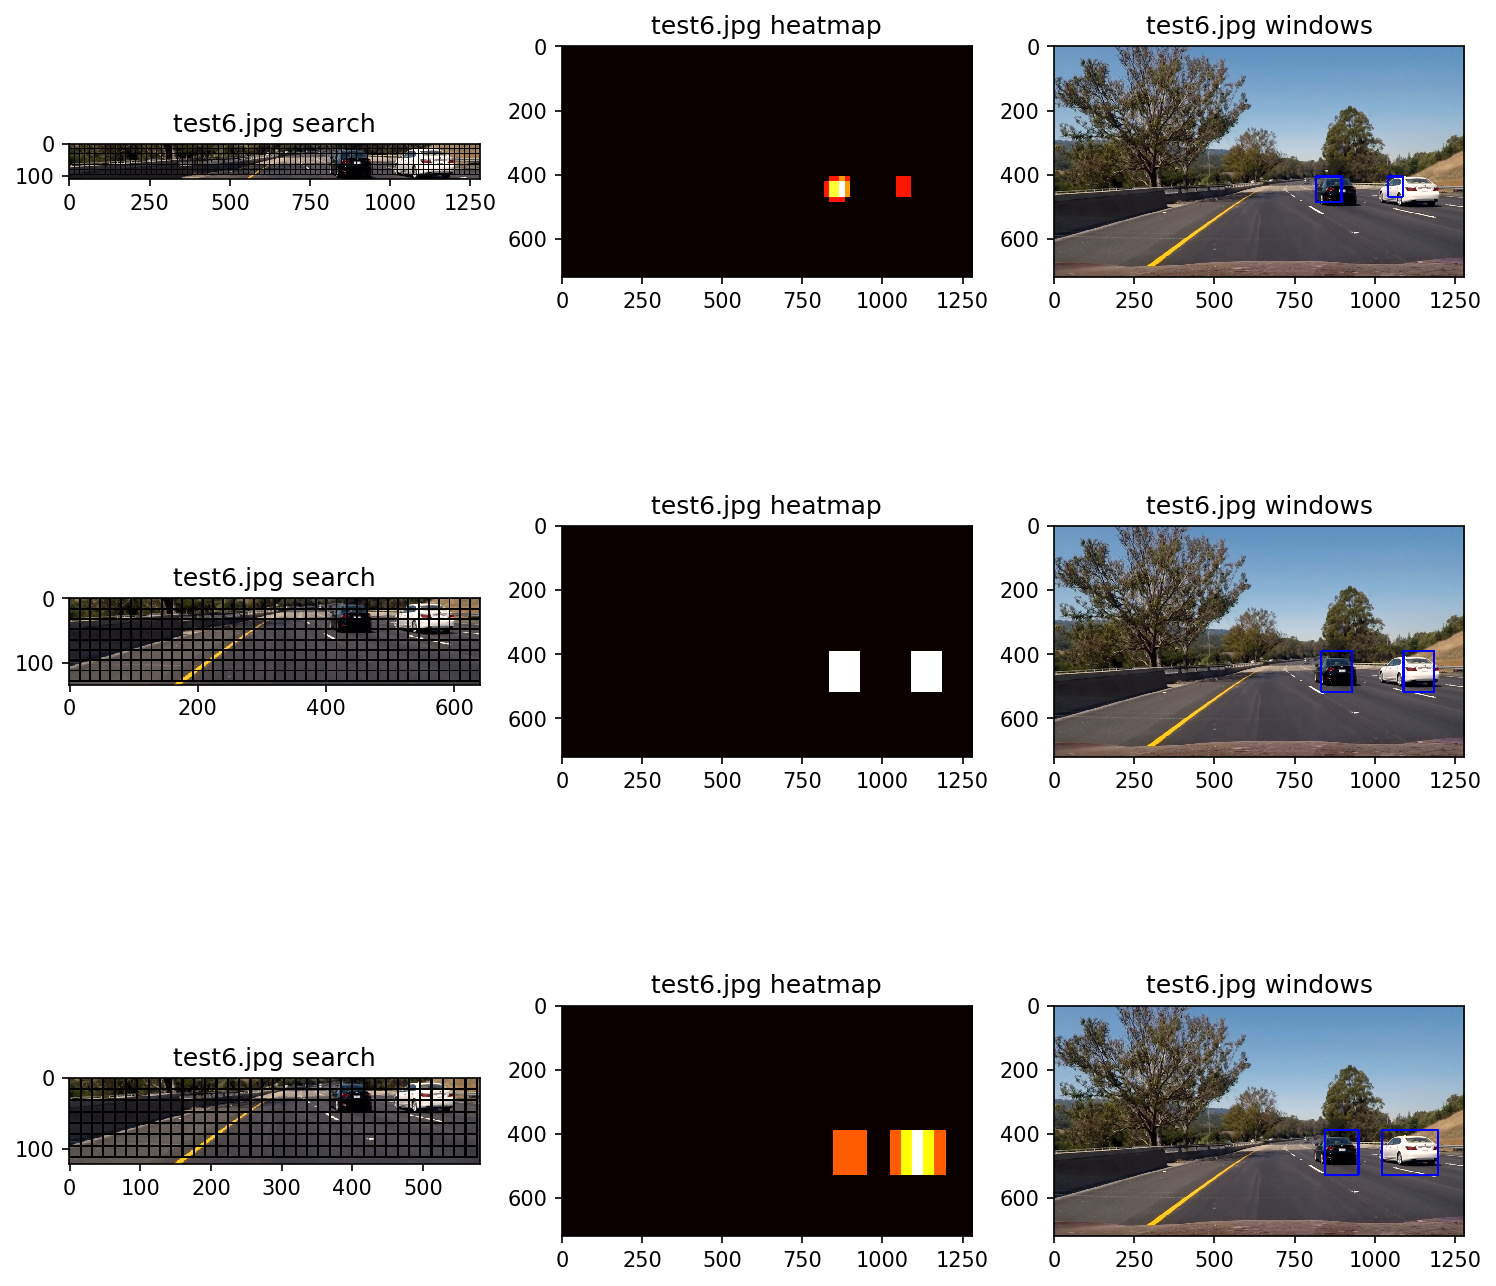

In [22]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, spatial_params, hoc_params, hog_params):
    from helper import convert_colour, grad_hist, bin_spatial, color_hist
    
    hog_params = hog_params.copy()
    hog_conv = hog_params.pop('conv')
    hog_channels = hog_params.pop('channels')

    draw_img = np.copy(img)
    window_img = np.copy(img)
    img = img.astype(np.float32)/255

    # Make a heatmap of zeros
    heatmap = np.zeros_like(draw_img[:,:,0])

    img_tosearch = img[ystart:ystop,:,:]

    if hog_conv is not None:
        ctrans_tosearch = convert_colour(img_tosearch, hog_conv)
    else:
        ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    window_img = np.copy(img_tosearch)

    # Compute individual channel HOG features for the entire image
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // hog_params['pix_per_cell']) - hog_params['cell_per_block'] + 1
    nyblocks = (ch1.shape[0] // hog_params['pix_per_cell']) - hog_params['cell_per_block'] + 1

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // hog_params['pix_per_cell']) - hog_params['cell_per_block'] + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    hog1 = grad_hist(ch1, feature_vec=False, **hog_params)
    hog2 = grad_hist(ch2, feature_vec=False, **hog_params)
    hog3 = grad_hist(ch3, feature_vec=False, **hog_params)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*hog_params['pix_per_cell']
            ytop = ypos*hog_params['pix_per_cell']

            # Extract the image patch for color features
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            spatial_features = bin_spatial(subimg, **spatial_params)
            hist_features = color_hist(subimg, **hoc_params)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            cv2.rectangle(window_img, (xleft, ytop), (xleft+window, ytop+window), (0,0,255),2)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,
                              (xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,255),2)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1

    return draw_img, heatmap, window_img

def simple_process_image(img, ystart, ystop, scale):
    from helper import apply_threshold, draw_labeled_bboxes
    out_img, heatmap, window_img = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                             spatial_params, hoc_params, hog_params)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap, window_img

example_images = glob.glob('test_images/test*jpg')

images=[]
titles=[]

mul = 1

for img_src in example_images[5:]:
    img = mpimg.imread(img_src)
    if img.shape != (1280, 720, 3): img = cv2.resize(img, dsize=(1280, 720))
    imheight = img.shape[0]
    imwidth = img.shape[0]

    draw_img1, heatmap1, window_img1 = simple_process_image(np.copy(img), 390, 500, 1)
    images.append(window_img1)
    titles.append(img_src.split('\\')[-1]+' search')
    images.append(heatmap1)
    titles.append(img_src.split('\\')[-1]+' heatmap')
    images.append(draw_img1)
    titles.append(img_src.split('\\')[-1]+' windows')
#     heatmap = heatmap1
#     images.append(heatmap)
#     titles.append(img_src+' combined heatmap')

    draw_img2, heatmap2, window_img2 = simple_process_image(np.copy(img), 390, 660, 2)
    images.append(window_img2)
    titles.append(img_src.split('\\')[-1]+' search')
    images.append(heatmap2)
    titles.append(img_src.split('\\')[-1]+' heatmap')
    images.append(draw_img2)
    titles.append(img_src.split('\\')[-1]+' windows')
#     heatmap = cv2.addWeighted(heatmap, mul, heatmap2, mul, 0)
#     images.append(heatmap)
#     titles.append(img_src+' combined heatmap')

    draw_img3, heatmap3, window_img3 = simple_process_image(np.copy(img), 390, 660, 2.2)
    images.append(window_img3)
    titles.append(img_src.split('\\')[-1]+' search')
    images.append(heatmap3)
    titles.append(img_src.split('\\')[-1]+' heatmap')
    images.append(draw_img3)
    titles.append(img_src.split('\\')[-1]+' windows')
#     heatmap = cv2.addWeighted(heatmap, mul, heatmap3, mul, 0)
#     images.append(heatmap)
#     titles.append(img_src+' combined heatmap')

    break

dpi = 150
figheight = int(imheight/dpi) # default 80ppi
figwidth = int(imwidth/dpi)
n_examples = 3 #len(example_images)*3
    
fig = plt.figure(figsize=(figwidth*3,figheight*n_examples), dpi=dpi) # w, h
visualise(fig, n_examples, 3, images, titles)

## Visualising vehicle detection in images

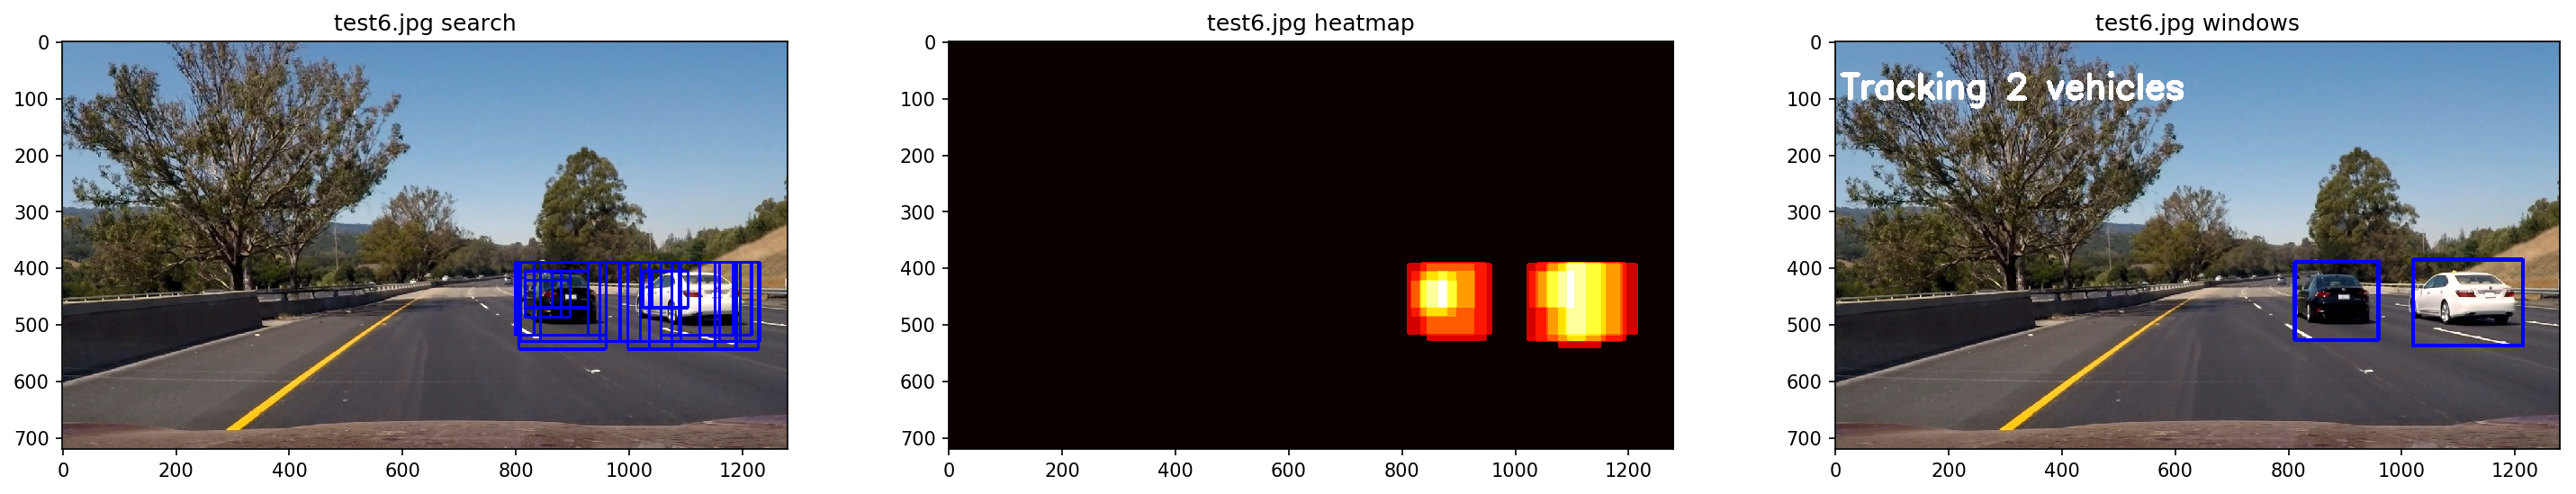

In [25]:
example_images = glob.glob('test_images/test*jpg')
sorted_images = example_images
#example_images = glob.glob('test_images/project_video/frames1/*jpg')
#sorted_images = sorted(example_images, key=lambda a: int(a.split("\\")[1].split(".")[0].split("e")[1]))


images=[]
titles=[]

# search_params = {
#     'ystart'    : (460, 430, 400),
#     'ystop'     : (660, 630, 600),
#     'scale'     : (2, 1.8, 1.6),
#     'threshold' : 2
# }
search_params = {
    'ystart'    : (390, 390, 390, 390),
    'ystop'     : (660, 660, 660, 500),
    'scale'     : (2.4, 2.2, 2, 1),
    'threshold' : 2
}

vt_image = VehicleTracking(svc, X_scaler, spatial_params, hoc_params, hog_params, search_params)
#vt_image.processing_video = True

for img_src in sorted_images[5:]:
    img = mpimg.imread(img_src)
    if img.shape != (1280, 720, 3): img = cv2.resize(img, dsize=(1280, 720))
    imheight = img.shape[0] # rows
    imwidth = img.shape[1] # cols
    labeled_img = vt_image.pipeline(img)
    images.append(vt_image.window_image)
    titles.append(img_src.split('\\')[-1]+' search')
    images.append(vt_image.heatmap)
    titles.append(img_src.split('\\')[-1]+' heatmap')
    images.append(labeled_img)
    titles.append(img_src.split('\\')[-1]+' windows')
    
    break

dpi = 150
figheight = int(imheight/dpi) # default 80ppi
figwidth = int(imwidth/dpi)
n_examples = 1 #len(example_images)
    
fig = plt.figure(figsize=(figwidth*3,figheight*n_examples), dpi=dpi) # w, h
visualise(fig, n_examples, 3, images, titles)

## Processing video frames

In [ ]:
example_images = glob.glob('test_images/test*jpg')
sorted_images = example_images

#example_images = glob.glob('test_images/test_video/frames/*jpg')
#example_images = glob.glob('test_images/project_video/frames1/*jpg')
#example_images = glob.glob('test_images/project_video/frames2/*jpg')
#sorted_images = sorted(example_images, key=lambda a: int(a.split("\\")[1].split(".")[0].split("e")[1]))

images=[]
titles=[]

vt_image = VehicleTracking(svc, X_scaler, spatial_params, hoc_params, hog_params, search_params)
#vt_image.processing_video = True
#vt_image.debug_mode = True

for img_src in sorted_images:
    if vt_image.debug_mode: print(img_src)
    img = mpimg.imread(img_src)
    if img.shape != (1280, 720, 3): img = cv2.resize(img, dsize=(1280, 720))
    labeled_img = vt_image.pipeline(img)
    mpimg.imsave('output_images/'+img_src[12:], labeled_img)
    mpimg.imsave('output_images/'+img_src[12:].split(".")[0]+'_w.jpg', vt_image.window_image)
    mpimg.imsave('output_images/'+img_src[12:].split(".")[0]+'_h.jpg', vt_image.heatmap)
    if vt_image.debug_mode: print('\n')

## Processing a video stream

In [27]:
#video_src = 'test_images/test_video/test_video.mp4'

search_params = {
    'ystart'    : (390, 390, 390, 390),
    'ystop'     : (660, 660, 660, 500),
    'scale'     : (2.4, 2.2, 2, 1),
    'threshold' : 2
}

video_src = 'test_images/project_video/project_video.mp4'
output_video = 'output_images/'+video_src[12:]

vt_video = VehicleTracking(svc, X_scaler, spatial_params, hoc_params, hog_params, search_params)
vt_video.processing_video = True

input_clip = VideoFileClip(video_src)#.subclip(38,42)
processed_clip = input_clip.fl_image(vt_video.pipeline)
processed_clip.write_videofile(output_video, audio=False)

input_clip.reader.close()
input_clip.audio.reader.close_proc()
processed_clip.reader.close()
processed_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video output_images/project_video/project_video.mp4
[MoviePy] Writing video output_images/project_video/project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:05<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video/project_video.mp4 

